In [1]:
import tensorflow as tf
import os
from src.utils import reload_model_from_epoch
from src.modeling.preprocess import load, resize, load_image_and_sketch
from src.preprocessing import find_sketch_threshold, get_black_border_percentage, dog
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from tensorflow.io import read_file, decode_jpeg
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import matplotlib.patches as patches

In [2]:
def get_example_sketches_at_thresholds(image_file, fill_space_thresholds):
    image = Image.open(image_file)
    
    sketches = []
    
    for threshold in fill_space_thresholds:
        sketches.append(find_sketch_threshold(image, fill_space_threshold = threshold))
        
    return sketches

In [67]:
def display_sketch_thresholds(image_file, fill_space_thresholds, sketches):
    fig, ax = plt.subplots(1, 5, figsize = (18, 10));

    for i in range(4):
        ax[i].imshow(sketches[i][0], cmap = 'gray');
        ax[i].set_xlabel(f'Threshold {fill_space_thresholds[i]}\nGamma: {sketches[i][1]}',
                         labelpad = 10, fontsize = 16);
        ax[i].get_xaxis().set_ticks([]);
        ax[i].get_yaxis().set_ticks([]);

    ax[4].imshow(Image.open(image_file), cmap = 'gray');
    ax[4].set_xlabel('Ground-Truth', labelpad = 10, fontsize = 16);
    ax[4].get_xaxis().set_ticks([]);
    ax[4].get_yaxis().set_ticks([]);
    plt.subplots_adjust(wspace = 0, hspace = 0);
    
    return fig, ax

In [2]:
image_files = [
    '../data/raw/actual_owls/grayscale/Owl_Grayscale_0045.jpg',
    '../data/raw/actual_owls/grayscale/Owl_Grayscale_0534.jpg'
]

# fill_space_thresholds = [0.01, 0.03, 0.05, 0.07]
# sketch_groupings = [get_example_sketches_at_thresholds(image, fill_space_thresholds) for image in image_files]

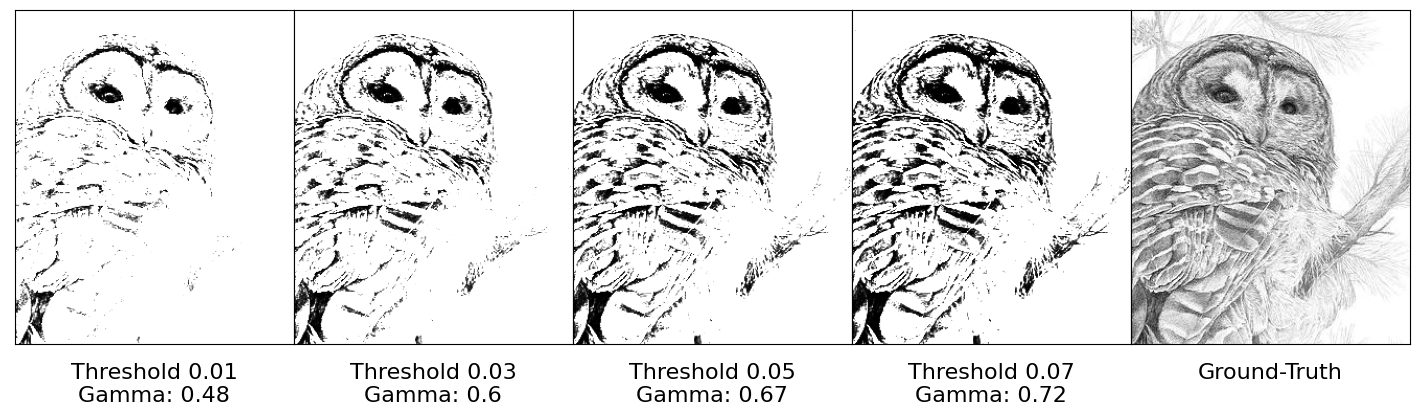

In [73]:
fig = display_sketch_thresholds(image_files[0], fill_space_thresholds, sketch_groupings[0]);
plt.savefig('../visualizations/DoG/sketch_thresholds_01.png', format = 'png', bbox_inches = 'tight');
plt.show();

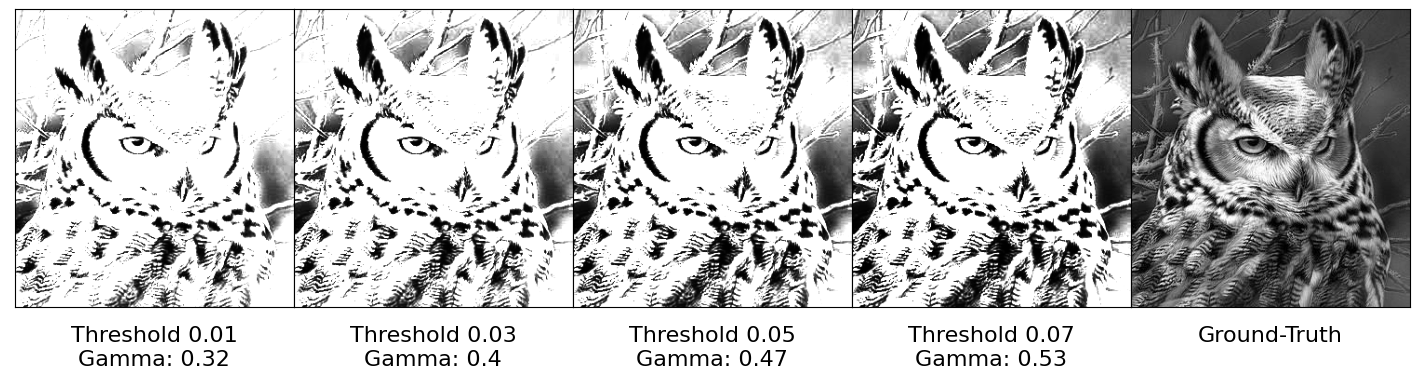

In [74]:
fig = display_sketch_thresholds(image_files[1], fill_space_thresholds, sketch_groupings[1])
plt.savefig('../visualizations/DoG/sketch_thresholds_02.png', format = 'png', bbox_inches = 'tight');
plt.show();

In [37]:
def display_dog_mixtures(gauss_mixtures, gammas):
    fig, ax = plt.subplots(1, 4, figsize = (14, 10));

    for i in range(4):
        ax[i].imshow(np.uint8(gauss_mixtures[i]), cmap = 'gray', vmin = 0, vmax = 255);
        ax[i].set_xlabel(f'Gamma: {gammas[i]}', labelpad = 10, fontsize = 16);
        ax[i].get_xaxis().set_ticks([]);
        ax[i].get_yaxis().set_ticks([]);
    plt.subplots_adjust(wspace = 0, hspace = 0);
    
    return fig, ax

In [25]:
gammas = [0.48, 0.6, 0.67, 0.72]

gauss_blurs = dog(np.array(Image.open(image_files[0])), size = (0, 0), sigma = 0.6, k = 200, gamma = 0.98)[0:2]
gauss_mixtures = [dog(np.array(Image.open(image_files[0])), size = (0, 0), sigma = 0.6, k = 200, gamma = gamma)[-1]\
                         for gamma in gammas]

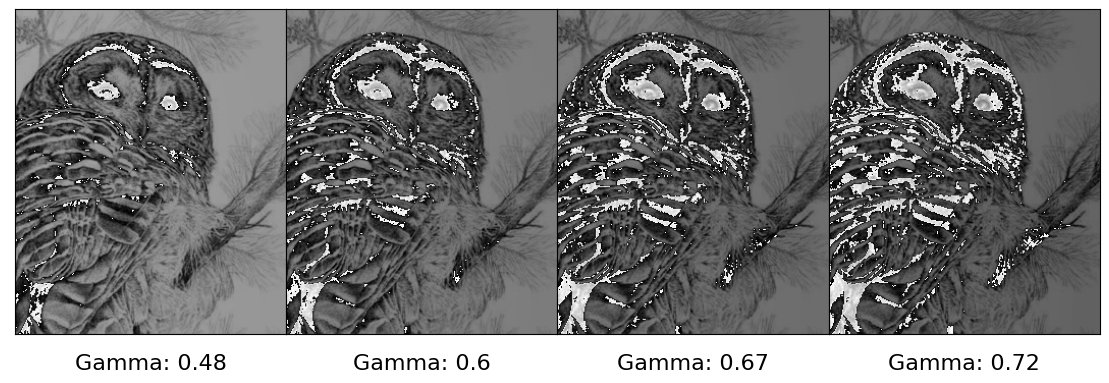

In [38]:
dog_mixtures = display_dog_mixtures(gauss_mixtures, gammas)
plt.savefig('../visualizations/DoG/gauss_mixtures.png', format = 'png', bbox_inches = 'tight');
plt.show()

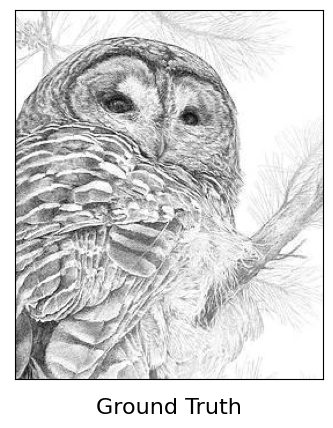

In [44]:
plt.imshow(Image.open(image_files[0]), cmap = 'gray', vmin = 0, vmax = 255);
plt.xlabel('Ground Truth', labelpad = 10, fontsize = 16);
plt.xticks([], []);
plt.yticks([], []);
plt.savefig('../visualizations/DoG/ground_truth_owl.png', format = 'png', bbox_inches = 'tight')

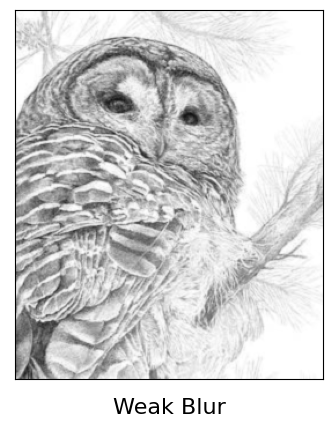

In [45]:
plt.imshow(Image.fromarray(gauss_blurs[0]), cmap = 'gray', vmin = 0, vmax = 255);
plt.xlabel('Weak Blur', labelpad = 10, fontsize = 16);
plt.xticks([], []);
plt.yticks([], []);
plt.savefig('../visualizations/DoG/weak_gauss_blur.png', format = 'png', bbox_inches = 'tight')

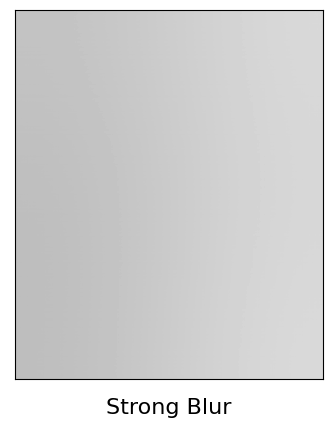

In [46]:
plt.imshow(Image.fromarray(gauss_blurs[1]), cmap = 'gray', vmin = 0, vmax = 255);
plt.xlabel('Strong Blur', labelpad = 10, fontsize = 16);
plt.xticks([], []);
plt.yticks([], []);
plt.savefig('../visualizations/DoG/strong_gauss_blur.png', format = 'png', bbox_inches = 'tight')

In [39]:
def create_images_with_border(inverted_image, regular_image, border):
    left_inv, top_inv, right_inv, bottom_inv = ImageOps._border((inverted_image.width * border,
                                                                 inverted_image.height * border))
    
    left_bound_inv, top_bound_inv, right_bound_inv, bot_bound_inv =\
                    (int(left_inv), int(top_inv),
                     int(inverted_image.size[0] - right_inv), int(inverted_image.size[1] - bottom_inv))
    
    left_reg, top_reg, right_reg, bottom_reg = ImageOps._border((regular_image.width * border,
                                                                 regular_image.height * border))
    
    left_bound_reg, top_bound_reg, right_bound_reg, bot_bound_reg =\
                    (int(left_reg), int(top_reg),
                     int(regular_image.size[0] - right_reg), int(regular_image.size[1] - bottom_reg))
    
    black_border_percentage_inv = get_black_border_percentage(inverted_image, border = border)
    black_border_percentage_reg = get_black_border_percentage(regular_image, border = border)
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 12))
    
    ax[0].imshow(inverted_image, cmap = 'gray', vmin = 0, vmax = 255)
    ax[0].set_xlabel(f'BB%: {black_border_percentage_inv:0.4f}', labelpad = 10, fontsize = 16);
    ax[0].set_title('Inverted', pad = 10, fontsize = 24)
    ax[1].imshow(regular_image, cmap = 'gray', vmin = 0, vmax = 255)
    ax[1].set_title('Regular', pad = 10, fontsize = 24)
    ax[1].set_xlabel(f'BB%: {black_border_percentage_reg:0.4f}', labelpad = 10, fontsize = 16);
    
    for axis in ax:
        axis.get_xaxis().set_ticks([], []);
        axis.get_yaxis().set_ticks([], []);
    
    if black_border_percentage_inv < 0.4:
        color_inv = 'green'
        color_reg = 'red'
    else:
        color_inv = 'red'
        color_reg = 'green'
    
    rect_inv = patches.Rectangle((left_bound_inv, bot_bound_inv),
                             right_bound_inv - left_bound_inv,
                             top_bound_inv - bot_bound_inv,
                             linewidth = 1,
                             edgecolor = color_inv,
                             facecolor = 'none')
    
    rect_reg = patches.Rectangle((left_bound_reg, bot_bound_reg),
                         right_bound_reg - left_bound_reg,
                         top_bound_reg - bot_bound_reg,
                         linewidth = 1,
                         edgecolor = color_reg,
                         facecolor = 'none')
    
    ax[0].add_patch(rect_inv)
    ax[1].add_patch(rect_reg)
    
    plt.subplots_adjust(wspace = 0, hspace = 0);
    
    return fig, ax

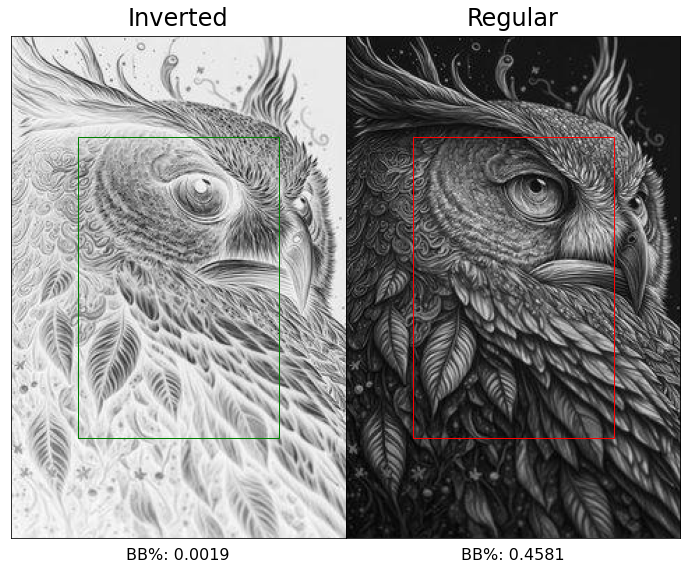

In [40]:
inverted_image_file = '../data/raw/actual_owls/inverted/Owl_Inverted_0001.jpg'
regular_image_file = '../data/raw/actual_owls/grayscale/Owl_Grayscale_0001.jpg'
inverted_image = Image.open(inverted_image_file)
regular_image = Image.open(regular_image_file)
fig = create_images_with_border(inverted_image, regular_image, border = 0.2)
plt.savefig('../visualizations/borders/pair_01.png', format = 'png', bbox_inches = 'tight')
plt.show()

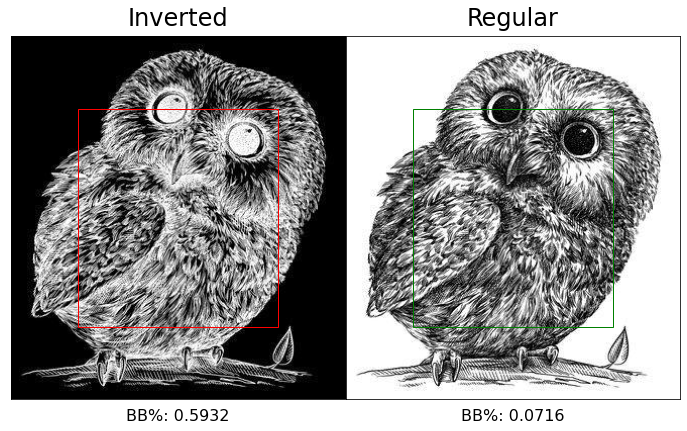

In [42]:
inverted_image_file = '../data/raw/actual_owls/inverted/Owl_Inverted_0012.jpg'
regular_image_file = '../data/raw/actual_owls/grayscale/Owl_Grayscale_0012.jpg'
inverted_image = Image.open(inverted_image_file)
regular_image = Image.open(regular_image_file)
fig = create_images_with_border(inverted_image, regular_image, border = 0.2)
plt.savefig('../visualizations/borders/pair_02.png', format = 'png', bbox_inches = 'tight')
plt.show()

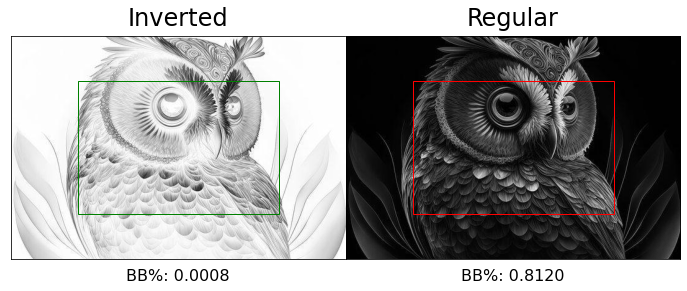

In [43]:
inverted_image_file = '../data/raw/actual_owls/inverted/Owl_Inverted_0025.jpg'
regular_image_file = '../data/raw/actual_owls/grayscale/Owl_Grayscale_0025.jpg'
inverted_image = Image.open(inverted_image_file)
regular_image = Image.open(regular_image_file)
fig = create_images_with_border(inverted_image, regular_image, border = 0.2)
plt.savefig('../visualizations/borders/pair_03.png', format = 'png', bbox_inches = 'tight')
plt.show()

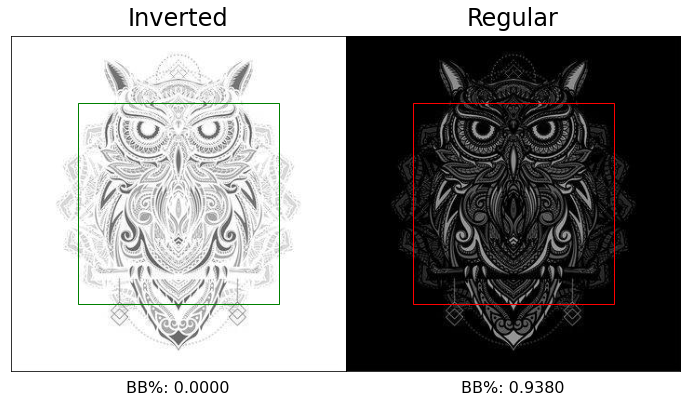

In [44]:
inverted_image_file = '../data/raw/actual_owls/inverted/Owl_Inverted_0054.jpg'
regular_image_file = '../data/raw/actual_owls/grayscale/Owl_Grayscale_0054.jpg'
inverted_image = Image.open(inverted_image_file)
regular_image = Image.open(regular_image_file)
fig = create_images_with_border(inverted_image, regular_image, border = 0.2)
plt.savefig('../visualizations/borders/pair_04.png', format = 'png', bbox_inches = 'tight')
plt.show()

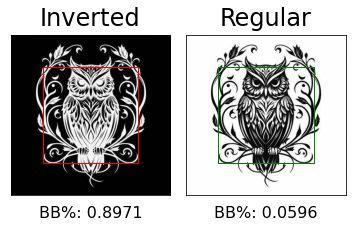

In [30]:
inverted_image_file = '../data/raw/actual_owls/inverted/Owl_Inverted_0065.jpg'
regular_image_file = '../data/raw/actual_owls/grayscale/Owl_Grayscale_0065.jpg'
inverted_image = Image.open(inverted_image_file)
regular_image = Image.open(regular_image_file)
fig = create_images_with_border(inverted_image, regular_image, border = 0.2)
plt.savefig('../visualizations/borders/pair_04.png', format = 'png', bbox_inches = 'tight')
plt.show()

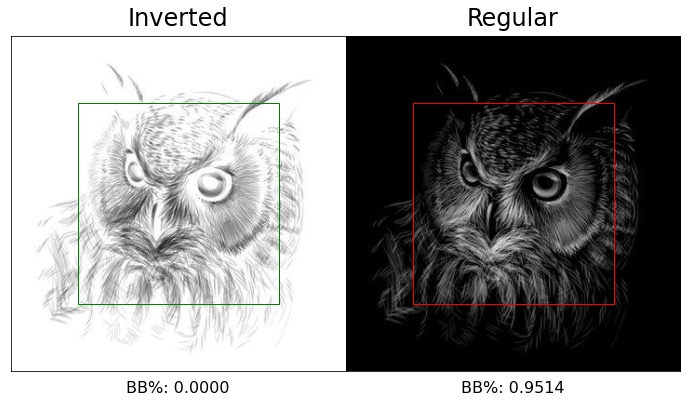

In [45]:
inverted_image_file = '../data/raw/actual_owls/inverted/Owl_Inverted_0084.jpg'
regular_image_file = '../data/raw/actual_owls/grayscale/Owl_Grayscale_0084.jpg'
inverted_image = Image.open(inverted_image_file)
regular_image = Image.open(regular_image_file)
fig = create_images_with_border(inverted_image, regular_image, border = 0.2)
plt.savefig('../visualizations/borders/pair_05.png', format = 'png', bbox_inches = 'tight')
plt.show()